# 安装依赖

- https://github.com/milesial/Pytorch-UNet/tree/master
- https://github.com/njcronin/DL_Track
- https://github.com/njcronin/DL_Track/blob/master/Labelling_Instructions.pdf

In [1]:
!pip install scipy scikit-image torch torchvision pathlib wandb segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Preparing metadata (setup.py) ... - done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=38488b49d0f34cdcf8dfd7ad1d4486bfde9839d54764fd8905ff49d516f46d0a
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=dbc0719289614e1c2666c10c1ce0c6225096c3985888a372eb1a927d9487da6f
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorch pretrainedmodels


# 引用依赖包

In [2]:
%config Completer.use_jedi = False

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

import torch
import torch.nn as nn
from torchvision import models
from torchvision.transforms import v2
from torch.nn.functional import relu, pad
from torch.utils.data import Dataset, DataLoader, random_split

from PIL import Image
from typing import Tuple
from pathlib import Path

import torch
from torch import nn, Tensor
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
import wandb
import logging

/opt/conda/lib/python3.10/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/opt/conda/lib/python3.10/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https:/

## U-Net 网络

In [4]:

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(DoubleConv,self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size=3, dropout = 0.1):
        super(Down, self).__init__()
        self.double_conv = DoubleConv(in_channels, out_channels, kernel_size)
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            nn.Dropout2d(p=dropout),
        )

    def forward(self, x):
        skip_out = self.double_conv(x)
        down_output = self.maxpool_conv(skip_out)
        return (down_output, skip_out)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, kernel_size = 2, dropout = 0.1, stride = 2):
        super().__init__()
        
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride)
        
        self.conv = nn.Sequential(
            nn.Dropout2d(p=dropout),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x1, x2):
        x = self.up(x1)
        x = torch.cat([x, x2], dim = 1)
        return self.conv(x)
    

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, n_filters = 64, bilinear=False):
        super(UNet, self).__init__()
        self.n_classes = n_classes
        self.n_channels = n_channels
        kernel_size = 3
        dropout = 0.25

        self.down1 = Down(n_channels, n_filters, kernel_size, dropout)
        self.down2 = Down(n_filters, n_filters * 2, kernel_size, dropout)
        self.down3 = Down(n_filters * 2, n_filters * 4, kernel_size, dropout)
        self.down4 = Down(n_filters * 4, n_filters * 8, kernel_size, dropout)
        
        self.bottle_conv = DoubleConv(n_filters * 8, n_filters * 16, kernel_size)
        
        kernel_size = kernel_size - 1
        self.up4 = Up(n_filters * 16, n_filters * 8, kernel_size, dropout)
        self.up3 = Up(n_filters * 8, n_filters * 4, kernel_size, dropout)
        self.up2 = Up(n_filters * 4, n_filters * 2, kernel_size, dropout)
        self.up1 = Up(n_filters * 2, n_filters, kernel_size, dropout)
        
        self.outc = nn.Conv2d(n_filters, n_classes, kernel_size=1)
        

    def forward(self, x):
        
        x, skip1 = self.down1(x)
        x, skip2 = self.down2(x)
        x, skip3 = self.down3(x)
        x, skip4 = self.down4(x)
        
        x = self.bottle_conv(x)
        
        x = self.up4(x, skip4)
        x = self.up3(x, skip3)
        x = self.up2(x, skip2)
        x = self.up1(x, skip1)
        
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.bottle_conv = torch.utils.checkpoint(self.bottle_conv)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

# 定义数据集加载器

In [5]:
# TODO: image和mask名称不一样时跳过
class APODataSet(Dataset):
    # 格式不对的异常数据
    invalid_img = [10, 184, 185]
    def __init__(self, img_dir, mask_dir: str, size) -> None:
        # 获取所有图片路径
        self.img_paths = list(Path(img_dir).glob("*"))
        self.mask_paths = list(Path(mask_dir).glob("*"))
        for idx in self.invalid_img:
            del self.img_paths[idx]
            del self.mask_paths[idx]
        
        
        # 设置 transforms
        self.transform = v2.Compose([     v2.Resize(size), 
                                             v2.RandomHorizontalFlip(),  # 随机水平翻转
                                             v2.RandomVerticalFlip(),    # 随机垂直旋转
                                             v2.RandomRotation(10) ,     # 随机旋转 （-10,10）度
                                             v2.ToImageTensor(), v2.ConvertImageDtype()])
#         self.transform = transforms.Compose([transforms.PILToTensor()])

    # 使用函数加载原始图像
    def load_orig_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.img_paths[index]
        return Image.open(image_path) 
    
    # 使用函数加载tmask图像
    def load_mask_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.mask_paths[index]
        return Image.open(image_path) 

    #  重写 __len__() 方法 (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.img_paths)

    # 重写 __getitem__() 方法 (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        "Returns one sample of data, image and mask (X, y)."
        orig_img = self.load_orig_image(index)
        mask_img = self.load_mask_image(index)
        
        seed = np.random.randint(2147483647)
        torch.manual_seed(seed)   # 指定同样的随机种子，以保证图片和label的旋转（水平、垂直和rotation）一致
        orig_img = self.transform(orig_img)
        torch.manual_seed(seed)  # 指定同样的随机种子，以保证图片和label的旋转（水平、垂直和rotation）一致
        mask_img = self.transform(mask_img)
#         mask_img = mask_img[0]
#         if orig_img.size()[0] != 3:
#             print("{}: orig_img size: {}".format(index,orig_img.size()))
#             return None
        # return data, mask (X, y)
        return orig_img, mask_img


# 加载数据集

In [6]:
dataset =  APODataSet(img_dir = "/kaggle/input/dltrack/apo_images",
                      mask_dir = "/kaggle/input/dltrack/apo_masks",
                     size = [512, 512])

total = len(dataset)
train_size = int(0.8*total)
validate_size = total - train_size
train_data, validate_data = random_split(dataset, [train_size, validate_size])
print("dataset info\ntotal: {}, train_size: {}, validate_size: {}".format(total, len(train_data), len(validate_data)))

trainloader = DataLoader(dataset=train_data,
                                     batch_size=2,
                                     num_workers=0,
                                     shuffle=True)

valloader = DataLoader(dataset=validate_data,
                                    batch_size=1, 
                                    num_workers=0, 
                                    shuffle=False)

dataset info
total: 571, train_size: 456, validate_size: 115


## 检查异常图片
要把找到的异常数据去除

In [7]:
for index in range(len(dataset)):
    orig_img, mask_img = dataset[index]
    if orig_img.size()[0] != 3:
        print("{}: orig_img size: {}".format(index,orig_img.size()))
print("[done]")

[done]


### 随机显示一张原始图片和其对应的标记图片

torch.Size([3, 512, 512])
showing image of 161: 


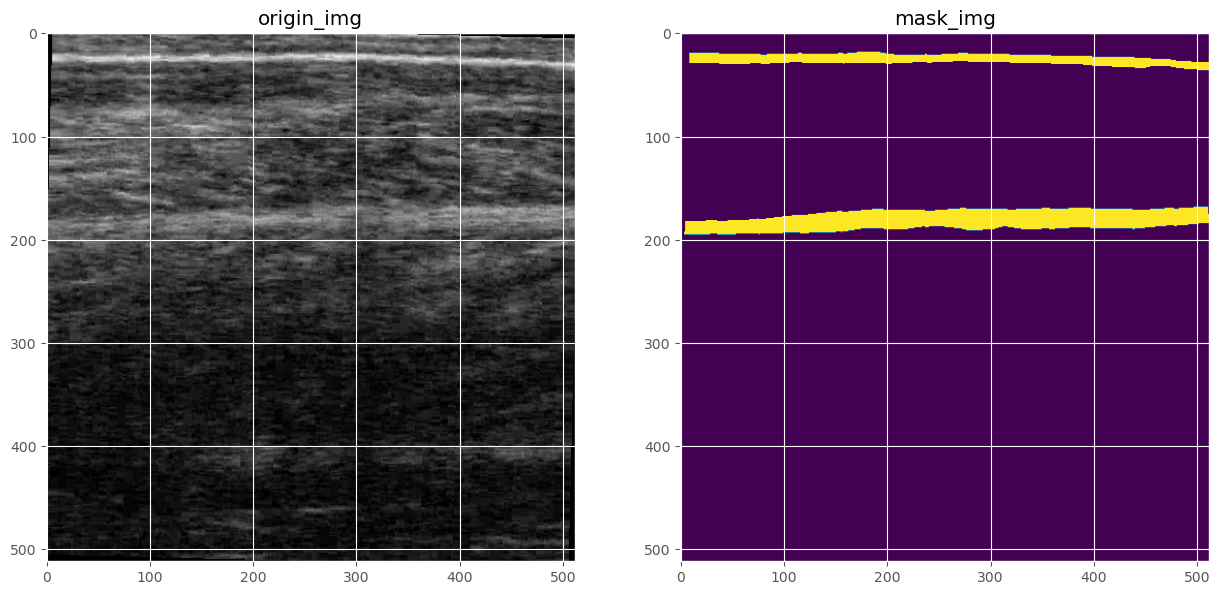

In [8]:
idx = random.randint(0, len(dataset))
orig_img, mask_img = dataset[idx]
print(orig_img.size())

transform = v2.ToPILImage()
print("showing image of {}: ".format(idx))

orig_img = transform(orig_img)
mask_img = transform(mask_img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 12))

ax1.imshow(orig_img)
ax1.set_title("origin_img")

ax2.imshow(mask_img)
ax2.set_title("mask_img")

plt.show()

# 训练网络

In [9]:

@torch.inference_mode()
def evaluate(net, dataloader, device, amp):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0
    iou_score = 0

    if isinstance(model, nn.DataParallel):
        n_classes = net.module.n_classes
    else:
        n_classes = net.n_classes
    criterion = nn.BCEWithLogitsLoss().cuda()
    dice_loss = smp.losses.DiceLoss(mode='binary', log_loss=True, from_logits = True).cuda()
   
    
    print("Validation round")
    # iterate over the validation set
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', position=0 ,leave=True):
            image, mask_true = batch

            # move images and labels to correct device and type
            image = image.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            mask_true = mask_true.to(device=device, dtype=torch.float32)

            # predict the mask
            mask_pred = net(image)
            dice_score += criterion(mask_pred, mask_true.float())
            dice_score += dice_loss(mask_pred, mask_true)
            
            tp, fp, fn, tn = smp.metrics.get_stats(mask_pred, mask_true.long(), mode='binary', threshold=0.5)
            iou_score += smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
            
    dice_loss = (dice_score / max(num_val_batches, 1))
    iou_score = (iou_score / max(num_val_batches, 1))
    print("Validation dice loss: {}, IoU Score {}".format(dice_loss, iou_score))
    return (dice_loss, iou_score)

## 设置wandb账号
用作统计与数据分析

In [10]:
os.environ['WANDB_API_KEY']='d561f1229ba7c4e207ca34042f29a43552a7447e'
!wandb login

wandb: Currently logged in as: torwayland (cupes-wangtao). Use `wandb login --relogin` to force relogin


In [11]:
import time
import torch.optim as optim
import segmentation_models_pytorch as smp

n_train = len(train_data)
n_val = len(validate_data)

sigmoid = nn.Sigmoid()

def train(model, device, 
          epochs: int = 60,
          learning_rate: float = 1e-5, 
          weight_decay: float = 1e-8,
          momentum: float = 0.999,
          batch_size: int = 2,
          amp: bool = False,
          val_percent: float = 0.1,
          gradient_clipping: float = 1.0):
    if isinstance(model, nn.DataParallel):
        n_classes = model.module.n_classes
        n_channels = model.module.n_channels
    else:
        n_classes = model.n_classes
        n_channels = model.n_channels
        
    # (Initialize logging)
    experiment = wandb.init(project='U-Net', resume='allow', anonymous='must')
    experiment.config.update(
        dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
             val_percent=val_percent, amp=amp)
    )

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Device:          {device.type}
        Mixed Precision: {amp}
    ''')

     # Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
#     optimizer = optim.RMSprop(model.parameters(),
#                               lr=learning_rate, weight_decay=weight_decay, momentum=momentum, foreach=True)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.BCEWithLogitsLoss().cuda()
    dice_loss = smp.losses.DiceLoss(mode='binary')
    
    global_step = 0
    
#     iou_metric = IoU

    # 5. Begin training
    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in trainloader:
                images, true_masks = batch

                assert images.shape[1] == n_channels, \
                    f'Network has been defined with {n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
                
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
                    masks_pred = model(images)
                    loss = criterion(masks_pred, true_masks.float())
                    loss += dice_loss(masks_pred, true_masks)
                    tp, fp, fn, tn = smp.metrics.get_stats(masks_pred, true_masks.long(), mode='binary', threshold=0.5)
                    iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    
                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                experiment.log({
                    'train iou': iou_score,
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (5 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in model.named_parameters():
                            tag = tag.replace('/', '.')
                            if not (torch.isinf(value) | torch.isnan(value)).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not (torch.isinf(value.grad) | torch.isnan(value.grad)).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score, iou_score = evaluate(model, valloader, device, amp)
                        logging.info('Validation Dice score: {}'.format(val_score))
                        
                        predict = sigmoid(masks_pred[0])
                        predict = torch.where(predict>0.5,torch.ones_like(predict),torch.zeros_like(predict))

                        try:
                            experiment.log({
                                'learning rate': optimizer.param_groups[0]['lr'],
                                'validation Dice': val_score,
                                'validation IoU Score': iou_score,
                                'images': wandb.Image(images[0].cpu()),
                                'masks': {
                                    'true': wandb.Image(true_masks[0].float().cpu()),
                                    'pred': wandb.Image(predict.float().cpu()),
                                },
                                'step': global_step,
                                'epoch': epoch,
                                **histograms
                            })
                        except:
                            pass
                        
                        model.train()
                        scheduler.step(val_score)
    experiment.finish()

if __name__ == '__main__':
    model = UNet(n_channels=3, n_classes=1, bilinear=False)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if torch.cuda.device_count() > 1:
        print("Let's use", torch.cuda.device_count(), "GPUs!")
        model = nn.DataParallel(model)

    model = model.to(memory_format=torch.channels_last)
    model.to(device)
    total_params = sum(p.numel() for p in model.parameters())
    print(f"模型参数量为：{total_params}")
    print("其详情为：")
    for name,parameters in model.named_parameters():
        print(name,':',parameters.size())
    train(model, device)

    

Let's use 2 GPUs!
模型参数量为：31043521
其详情为：
module.down1.double_conv.double_conv.0.weight : torch.Size([64, 3, 3, 3])
module.down1.double_conv.double_conv.0.bias : torch.Size([64])
module.down1.double_conv.double_conv.1.weight : torch.Size([64])
module.down1.double_conv.double_conv.1.bias : torch.Size([64])
module.down1.double_conv.double_conv.3.weight : torch.Size([64, 64, 3, 3])
module.down1.double_conv.double_conv.3.bias : torch.Size([64])
module.down1.double_conv.double_conv.4.weight : torch.Size([64])
module.down1.double_conv.double_conv.4.bias : torch.Size([64])
module.down2.double_conv.double_conv.0.weight : torch.Size([128, 64, 3, 3])
module.down2.double_conv.double_conv.0.bias : torch.Size([128])
module.down2.double_conv.double_conv.1.weight : torch.Size([128])
module.down2.double_conv.double_conv.1.bias : torch.Size([128])
module.down2.double_conv.double_conv.3.weight : torch.Size([128, 128, 3, 3])
module.down2.double_conv.double_conv.3.bias : torch.Size([128])
module.down2.doubl

wandb: Currently logged in as: torwayland (cupes-wangtao). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.16.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.15.5
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240118_073240-06wsinme
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run eternal-salad-22
wandb: ⭐️ View project at https://wandb.ai/cupes-wangtao/U-Net
wandb: 🚀 View run at https://wandb.ai/cupes-wangtao/U-Net/runs/06wsinme
Epoch 1/60:  20%|█▉        | 90/456 [00:16<00:58,  6.29img/s, loss (batch)=1.6] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.15batch/s]


Validation dice loss: 3.1496634483337402, IoU Score 0.31265944242477417


Epoch 1/60:  39%|███▉      | 180/456 [00:45<00:45,  6.01img/s, loss (batch)=1.51]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.10batch/s]


Validation dice loss: 2.907071113586426, IoU Score 0.24882927536964417


Epoch 1/60:  59%|█████▉    | 270/456 [01:14<00:31,  5.98img/s, loss (batch)=1.44]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  9.01batch/s]


Validation dice loss: 2.5332486629486084, IoU Score 0.4100703299045563


Epoch 1/60:  79%|███████▉  | 360/456 [01:43<00:16,  5.78img/s, loss (batch)=1.25]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 2.3509891033172607, IoU Score 0.4737096130847931


Epoch 1/60:  99%|█████████▊| 450/456 [02:14<00:01,  5.71img/s, loss (batch)=1.13]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 2.274214506149292, IoU Score 0.4715368449687958


Epoch 2/60:  18%|█▊        | 84/456 [00:14<01:03,  5.81img/s, loss (batch)=1.26]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 2.279843807220459, IoU Score 0.49938490986824036


Epoch 2/60:  38%|███▊      | 174/456 [00:44<00:48,  5.83img/s, loss (batch)=1.13]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 2.1890337467193604, IoU Score 0.5180785059928894


Epoch 2/60:  58%|█████▊    | 264/456 [01:13<00:32,  5.82img/s, loss (batch)=1.15]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 2.105513572692871, IoU Score 0.535348117351532


Epoch 2/60:  78%|███████▊  | 354/456 [01:43<00:17,  5.83img/s, loss (batch)=1.16]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 2.070952892303467, IoU Score 0.5303309559822083


Epoch 2/60:  97%|█████████▋| 444/456 [02:13<00:02,  5.90img/s, loss (batch)=1.11]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 2.0179331302642822, IoU Score 0.5106067657470703


Epoch 3/60:  17%|█▋        | 78/456 [00:13<01:04,  5.82img/s, loss (batch)=1.11]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 2.002580165863037, IoU Score 0.5481714606285095


Epoch 3/60:  37%|███▋      | 168/456 [00:43<00:48,  5.89img/s, loss (batch)=1.02]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.990147590637207, IoU Score 0.5327691435813904


Epoch 3/60:  57%|█████▋    | 258/456 [01:12<00:33,  5.92img/s, loss (batch)=0.972]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 1.9530636072158813, IoU Score 0.528016984462738


Epoch 3/60:  76%|███████▋  | 348/456 [01:42<00:18,  5.98img/s, loss (batch)=1.02] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 1.9422355890274048, IoU Score 0.5507965087890625


Epoch 3/60:  96%|█████████▌| 438/456 [02:12<00:03,  5.88img/s, loss (batch)=1.06]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.9584201574325562, IoU Score 0.5461530685424805


Epoch 4/60:  16%|█▌        | 72/456 [00:12<01:08,  5.64img/s, loss (batch)=1.24]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.8713757991790771, IoU Score 0.5211687088012695


Epoch 4/60:  36%|███▌      | 162/456 [00:42<00:50,  5.82img/s, loss (batch)=0.941]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.8545573949813843, IoU Score 0.5553836822509766


Epoch 4/60:  55%|█████▌    | 252/456 [01:11<00:35,  5.77img/s, loss (batch)=1.08] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.8897254467010498, IoU Score 0.5436456799507141


Epoch 4/60:  75%|███████▌  | 342/456 [01:41<00:19,  5.75img/s, loss (batch)=1.09]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.9144783020019531, IoU Score 0.5225570201873779


Epoch 4/60:  95%|█████████▍| 432/456 [02:11<00:04,  5.77img/s, loss (batch)=1]   

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.881902813911438, IoU Score 0.5489702820777893


Epoch 5/60:  14%|█▍        | 66/456 [00:11<01:07,  5.79img/s, loss (batch)=0.912]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.786029577255249, IoU Score 0.5567182302474976


Epoch 5/60:  34%|███▍      | 156/456 [00:41<00:51,  5.87img/s, loss (batch)=0.884]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.8120720386505127, IoU Score 0.53339684009552


Epoch 5/60:  54%|█████▍    | 246/456 [01:11<00:36,  5.71img/s, loss (batch)=1.16] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.7909380197525024, IoU Score 0.5447890162467957


Epoch 5/60:  74%|███████▎  | 336/456 [01:40<00:20,  5.76img/s, loss (batch)=0.906]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.786186695098877, IoU Score 0.5460221171379089


Epoch 5/60:  93%|█████████▎| 426/456 [02:10<00:05,  5.87img/s, loss (batch)=0.891]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.6953446865081787, IoU Score 0.5550077557563782


Epoch 6/60:  13%|█▎        | 60/456 [00:10<01:07,  5.84img/s, loss (batch)=1.02] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.7161163091659546, IoU Score 0.5457009673118591


Epoch 6/60:  33%|███▎      | 150/456 [00:39<00:52,  5.80img/s, loss (batch)=1.15]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.7631418704986572, IoU Score 0.531042754650116


Epoch 6/60:  53%|█████▎    | 240/456 [01:09<00:36,  5.88img/s, loss (batch)=0.942]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.6559720039367676, IoU Score 0.5408041477203369


Epoch 6/60:  72%|███████▏  | 330/456 [01:39<00:22,  5.70img/s, loss (batch)=0.892]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.7015776634216309, IoU Score 0.5358778834342957


Epoch 6/60:  92%|█████████▏| 420/456 [02:09<00:06,  5.66img/s, loss (batch)=0.953]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.6513010263442993, IoU Score 0.5633336305618286


Epoch 7/60:  12%|█▏        | 54/456 [00:09<01:08,  5.86img/s, loss (batch)=0.95] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.6691328287124634, IoU Score 0.5381171107292175


Epoch 7/60:  32%|███▏      | 144/456 [00:39<00:54,  5.68img/s, loss (batch)=0.961]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.600201964378357, IoU Score 0.5539293885231018


Epoch 7/60:  51%|█████▏    | 234/456 [01:08<00:38,  5.79img/s, loss (batch)=0.944]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.5926296710968018, IoU Score 0.5529531836509705


Epoch 7/60:  71%|███████   | 324/456 [01:38<00:22,  5.85img/s, loss (batch)=0.819]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.6897189617156982, IoU Score 0.5322498083114624


Epoch 7/60:  91%|█████████ | 414/456 [02:08<00:07,  5.80img/s, loss (batch)=0.824]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.520803689956665, IoU Score 0.5379593372344971


Epoch 8/60:  11%|█         | 48/456 [00:08<01:09,  5.91img/s, loss (batch)=0.794]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.5889619588851929, IoU Score 0.5686800479888916


Epoch 8/60:  30%|███       | 138/456 [00:37<00:55,  5.71img/s, loss (batch)=0.904]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.5632764101028442, IoU Score 0.5620643496513367


Epoch 8/60:  50%|█████     | 228/456 [01:08<00:39,  5.82img/s, loss (batch)=0.858]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.499690294265747, IoU Score 0.5674937963485718


Epoch 8/60:  70%|██████▉   | 318/456 [01:37<00:23,  5.90img/s, loss (batch)=0.843]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.499474048614502, IoU Score 0.5272952914237976


Epoch 8/60:  89%|████████▉ | 408/456 [02:07<00:08,  5.76img/s, loss (batch)=0.972]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.5018688440322876, IoU Score 0.566072940826416


Epoch 9/60:   9%|▉         | 42/456 [00:07<01:11,  5.79img/s, loss (batch)=0.883]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.5109944343566895, IoU Score 0.5587185621261597


Epoch 9/60:  29%|██▉       | 132/456 [00:37<00:56,  5.74img/s, loss (batch)=0.802]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.447430968284607, IoU Score 0.5519249439239502


Epoch 9/60:  49%|████▊     | 222/456 [01:06<00:40,  5.83img/s, loss (batch)=0.786]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.432469129562378, IoU Score 0.5694692730903625


Epoch 9/60:  68%|██████▊   | 312/456 [01:36<00:24,  5.91img/s, loss (batch)=0.745]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.4568819999694824, IoU Score 0.5590126514434814


Epoch 9/60:  88%|████████▊ | 402/456 [02:06<00:09,  5.80img/s, loss (batch)=0.85] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.4723504781723022, IoU Score 0.555348813533783


Epoch 10/60:   8%|▊         | 36/456 [00:06<01:11,  5.86img/s, loss (batch)=0.774]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.4523322582244873, IoU Score 0.5750571489334106


Epoch 10/60:  28%|██▊       | 126/456 [00:35<00:56,  5.86img/s, loss (batch)=0.76] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.4216619729995728, IoU Score 0.5579935908317566


Epoch 10/60:  47%|████▋     | 216/456 [01:05<00:41,  5.83img/s, loss (batch)=0.789]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.4587441682815552, IoU Score 0.5674722790718079


Epoch 10/60:  67%|██████▋   | 306/456 [01:35<00:30,  4.92img/s, loss (batch)=0.871]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.4974161386489868, IoU Score 0.5342821478843689


Epoch 10/60:  87%|████████▋ | 396/456 [02:05<00:10,  5.79img/s, loss (batch)=0.966]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.3517200946807861, IoU Score 0.5762647390365601


Epoch 11/60:   7%|▋         | 30/456 [00:05<01:13,  5.79img/s, loss (batch)=0.84] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.4219317436218262, IoU Score 0.5790680050849915


Epoch 11/60:  26%|██▋       | 120/456 [00:34<00:57,  5.81img/s, loss (batch)=0.794]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 1.4461925029754639, IoU Score 0.5642691254615784


Epoch 11/60:  46%|████▌     | 210/456 [01:04<00:42,  5.72img/s, loss (batch)=0.664]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.4208273887634277, IoU Score 0.5515427589416504


Epoch 11/60:  66%|██████▌   | 300/456 [01:34<00:26,  5.83img/s, loss (batch)=0.773]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.3430849313735962, IoU Score 0.5692453384399414


Epoch 11/60:  86%|████████▌ | 390/456 [02:04<00:11,  5.79img/s, loss (batch)=0.635]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.3936678171157837, IoU Score 0.5687232613563538


Epoch 12/60:   5%|▌         | 24/456 [00:04<01:13,  5.84img/s, loss (batch)=0.669]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.4246808290481567, IoU Score 0.5349801778793335


Epoch 12/60:  25%|██▌       | 114/456 [00:33<00:58,  5.80img/s, loss (batch)=0.752]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.3875844478607178, IoU Score 0.5476608872413635


Epoch 12/60:  45%|████▍     | 204/456 [01:03<00:42,  5.91img/s, loss (batch)=0.888]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.3680692911148071, IoU Score 0.5415667295455933


Epoch 12/60:  64%|██████▍   | 294/456 [01:33<00:27,  5.83img/s, loss (batch)=0.682]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.3233232498168945, IoU Score 0.5773105025291443


Epoch 12/60:  84%|████████▍ | 384/456 [02:03<00:12,  5.79img/s, loss (batch)=0.867]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.305214285850525, IoU Score 0.574462354183197


Epoch 13/60:   4%|▍         | 18/456 [00:03<01:15,  5.84img/s, loss (batch)=0.768]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.4121010303497314, IoU Score 0.5389590263366699


Epoch 13/60:  24%|██▎       | 108/456 [00:33<00:59,  5.84img/s, loss (batch)=0.65] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.3343349695205688, IoU Score 0.5670045018196106


Epoch 13/60:  43%|████▎     | 198/456 [01:02<00:44,  5.75img/s, loss (batch)=0.807]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.4582500457763672, IoU Score 0.5278221964836121


Epoch 13/60:  63%|██████▎   | 288/456 [01:32<00:28,  5.85img/s, loss (batch)=0.794]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.319939374923706, IoU Score 0.554427981376648


Epoch 13/60:  83%|████████▎ | 378/456 [02:02<00:13,  5.80img/s, loss (batch)=0.923]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.2809860706329346, IoU Score 0.5839623212814331


Epoch 14/60:   3%|▎         | 12/456 [00:02<01:16,  5.82img/s, loss (batch)=0.994]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.3902766704559326, IoU Score 0.5402385592460632


Epoch 14/60:  22%|██▏       | 102/456 [00:31<01:00,  5.88img/s, loss (batch)=0.579]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.3243327140808105, IoU Score 0.556804358959198


Epoch 14/60:  42%|████▏     | 192/456 [01:01<00:45,  5.76img/s, loss (batch)=1.08] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.3299481868743896, IoU Score 0.5613207221031189


Epoch 14/60:  62%|██████▏   | 282/456 [01:31<00:29,  5.90img/s, loss (batch)=0.658]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.2595723867416382, IoU Score 0.5828532576560974


Epoch 14/60:  82%|████████▏ | 372/456 [02:00<00:14,  5.85img/s, loss (batch)=0.685]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.2675708532333374, IoU Score 0.5761361122131348


Epoch 15/60:   1%|▏         | 6/456 [00:01<01:17,  5.81img/s, loss (batch)=0.903]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.3621827363967896, IoU Score 0.5156612396240234


Epoch 15/60:  21%|██        | 96/456 [00:30<01:01,  5.86img/s, loss (batch)=0.667]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.2506444454193115, IoU Score 0.5703161954879761


Epoch 15/60:  41%|████      | 186/456 [01:00<00:46,  5.84img/s, loss (batch)=0.638]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.3920001983642578, IoU Score 0.49251970648765564


Epoch 15/60:  61%|██████    | 276/456 [01:30<00:31,  5.68img/s, loss (batch)=0.68] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.2360749244689941, IoU Score 0.5715198516845703


Epoch 15/60:  80%|████████  | 366/456 [02:00<00:15,  5.84img/s, loss (batch)=0.755]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.2238625288009644, IoU Score 0.5855426788330078


Epoch 15/60: 100%|██████████| 456/456 [02:29<00:00,  5.91img/s, loss (batch)=0.588]

Validation round


Epoch 15/60: 100%|██████████| 456/456 [02:44<00:00,  2.78img/s, loss (batch)=0.588]


Validation dice loss: 1.220987319946289, IoU Score 0.5875020027160645


Epoch 16/60:  20%|█▉        | 90/456 [00:15<01:01,  5.93img/s, loss (batch)=0.534]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.1924227476119995, IoU Score 0.5905755758285522


Epoch 16/60:  39%|███▉      | 180/456 [00:45<00:46,  5.90img/s, loss (batch)=0.677]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.2312846183776855, IoU Score 0.5827863216400146


Epoch 16/60:  59%|█████▉    | 270/456 [01:14<00:32,  5.80img/s, loss (batch)=0.709]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.3160303831100464, IoU Score 0.5410736203193665


Epoch 16/60:  79%|███████▉  | 360/456 [01:44<00:16,  5.80img/s, loss (batch)=0.725]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.2751493453979492, IoU Score 0.5378438830375671


Epoch 16/60:  99%|█████████▊| 450/456 [02:14<00:01,  5.68img/s, loss (batch)=0.99]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.3307137489318848, IoU Score 0.5194966793060303


Epoch 17/60:  18%|█▊        | 84/456 [00:14<01:03,  5.87img/s, loss (batch)=0.666]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.1616723537445068, IoU Score 0.5895346403121948


Epoch 17/60:  38%|███▊      | 174/456 [00:44<00:48,  5.77img/s, loss (batch)=0.672]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.1716231107711792, IoU Score 0.583217978477478


Epoch 17/60:  58%|█████▊    | 264/456 [01:14<00:32,  5.86img/s, loss (batch)=0.552]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.162650465965271, IoU Score 0.580944836139679


Epoch 17/60:  78%|███████▊  | 354/456 [01:43<00:17,  5.84img/s, loss (batch)=0.773]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.1289646625518799, IoU Score 0.5753404498100281


Epoch 17/60:  97%|█████████▋| 444/456 [02:13<00:02,  5.82img/s, loss (batch)=0.565]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.1692016124725342, IoU Score 0.572490394115448


Epoch 18/60:  17%|█▋        | 78/456 [00:13<01:05,  5.79img/s, loss (batch)=0.666]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.2527854442596436, IoU Score 0.5157048106193542


Epoch 18/60:  37%|███▋      | 168/456 [00:43<00:49,  5.86img/s, loss (batch)=0.672]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.115846037864685, IoU Score 0.580390989780426


Epoch 18/60:  57%|█████▋    | 258/456 [01:12<00:34,  5.71img/s, loss (batch)=0.651]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.1614720821380615, IoU Score 0.5563523173332214


Epoch 18/60:  76%|███████▋  | 348/456 [01:42<00:18,  5.81img/s, loss (batch)=0.62] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.1766489744186401, IoU Score 0.5718449354171753


Epoch 18/60:  96%|█████████▌| 438/456 [02:12<00:03,  5.80img/s, loss (batch)=0.598]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.2222247123718262, IoU Score 0.5508826375007629


Epoch 19/60:  16%|█▌        | 72/456 [00:12<01:05,  5.88img/s, loss (batch)=0.6]  

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.1071995496749878, IoU Score 0.5980392694473267


Epoch 19/60:  36%|███▌      | 162/456 [00:42<00:50,  5.79img/s, loss (batch)=0.784]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.1692548990249634, IoU Score 0.5519526600837708


Epoch 19/60:  55%|█████▌    | 252/456 [01:12<00:35,  5.71img/s, loss (batch)=0.643]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 1.2865583896636963, IoU Score 0.49891170859336853


Epoch 19/60:  75%|███████▌  | 342/456 [01:41<00:19,  5.82img/s, loss (batch)=0.654]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.0888822078704834, IoU Score 0.5749741792678833


Epoch 19/60:  95%|█████████▍| 432/456 [02:11<00:04,  5.75img/s, loss (batch)=0.63] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 1.2031488418579102, IoU Score 0.5410537719726562


Epoch 20/60:  14%|█▍        | 66/456 [00:11<01:07,  5.80img/s, loss (batch)=0.666]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 1.1258666515350342, IoU Score 0.5759990215301514


Epoch 20/60:  34%|███▍      | 156/456 [00:41<00:51,  5.82img/s, loss (batch)=0.549]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.3023909330368042, IoU Score 0.47307366132736206


Epoch 20/60:  54%|█████▍    | 246/456 [01:11<00:36,  5.81img/s, loss (batch)=0.562]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 1.1026935577392578, IoU Score 0.578704833984375


Epoch 20/60:  74%|███████▎  | 336/456 [01:40<00:20,  5.84img/s, loss (batch)=0.634]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 1.1321234703063965, IoU Score 0.5654084086418152


Epoch 20/60:  93%|█████████▎| 426/456 [02:10<00:05,  5.83img/s, loss (batch)=0.79] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.1150250434875488, IoU Score 0.5725157260894775


Epoch 21/60:  13%|█▎        | 60/456 [00:10<01:06,  5.97img/s, loss (batch)=0.587]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 0.9929729700088501, IoU Score 0.5868308544158936


Epoch 21/60:  33%|███▎      | 150/456 [00:39<00:53,  5.75img/s, loss (batch)=0.626]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.2297871112823486, IoU Score 0.4992944002151489


Epoch 21/60:  53%|█████▎    | 240/456 [01:09<00:37,  5.77img/s, loss (batch)=0.956]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 1.1878869533538818, IoU Score 0.5136003494262695


Epoch 21/60:  72%|███████▏  | 330/456 [01:39<00:21,  5.78img/s, loss (batch)=0.589]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 1.1462147235870361, IoU Score 0.5350559949874878


Epoch 21/60:  92%|█████████▏| 420/456 [02:09<00:06,  5.76img/s, loss (batch)=0.651]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 0.9990367889404297, IoU Score 0.5926033854484558


Epoch 22/60:  12%|█▏        | 54/456 [00:09<01:09,  5.76img/s, loss (batch)=0.549]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.0458675622940063, IoU Score 0.5475617051124573


Epoch 22/60:  32%|███▏      | 144/456 [00:39<01:01,  5.05img/s, loss (batch)=0.58] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 1.010149359703064, IoU Score 0.5756861567497253


Epoch 22/60:  51%|█████▏    | 234/456 [01:08<00:38,  5.80img/s, loss (batch)=0.492]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 0.9773815274238586, IoU Score 0.5849466919898987


Epoch 22/60:  71%|███████   | 324/456 [01:38<00:22,  5.80img/s, loss (batch)=0.705]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 1.3330820798873901, IoU Score 0.4454179108142853


Epoch 22/60:  91%|█████████ | 414/456 [02:08<00:07,  5.80img/s, loss (batch)=0.656]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.0761737823486328, IoU Score 0.5388540029525757


Epoch 23/60:  11%|█         | 48/456 [00:08<01:09,  5.87img/s, loss (batch)=0.635]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 0.9908955693244934, IoU Score 0.5701690316200256


Epoch 23/60:  30%|███       | 138/456 [00:37<00:54,  5.82img/s, loss (batch)=0.554]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 0.998399019241333, IoU Score 0.5849443078041077


Epoch 23/60:  50%|█████     | 228/456 [01:07<00:39,  5.79img/s, loss (batch)=0.537]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 1.0234501361846924, IoU Score 0.5741370320320129


Epoch 23/60:  70%|██████▉   | 318/456 [01:37<00:24,  5.70img/s, loss (batch)=0.466]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 0.9518539905548096, IoU Score 0.5847035646438599


Epoch 23/60:  89%|████████▉ | 408/456 [02:07<00:08,  5.76img/s, loss (batch)=0.415]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 0.8997097015380859, IoU Score 0.5780311226844788


Epoch 24/60:   9%|▉         | 42/456 [00:07<01:12,  5.70img/s, loss (batch)=0.803]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 1.5323846340179443, IoU Score 0.35878148674964905


Epoch 24/60:  29%|██▉       | 132/456 [00:37<00:55,  5.82img/s, loss (batch)=0.534]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 0.9088924527168274, IoU Score 0.579505205154419


Epoch 24/60:  49%|████▊     | 222/456 [01:07<00:40,  5.77img/s, loss (batch)=0.53] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 0.9075865745544434, IoU Score 0.5816944241523743


Epoch 24/60:  68%|██████▊   | 312/456 [01:37<00:24,  5.80img/s, loss (batch)=0.523]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 0.9978179931640625, IoU Score 0.5495851635932922


Epoch 24/60:  88%|████████▊ | 402/456 [02:07<00:09,  5.83img/s, loss (batch)=0.784]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 0.885413408279419, IoU Score 0.5832046866416931


Epoch 25/60:   8%|▊         | 36/456 [00:06<01:11,  5.87img/s, loss (batch)=0.389]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 0.9320032596588135, IoU Score 0.5302022695541382


Epoch 25/60:  28%|██▊       | 126/456 [00:35<00:56,  5.80img/s, loss (batch)=0.677]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 0.8947027325630188, IoU Score 0.5591368675231934


Epoch 25/60:  47%|████▋     | 216/456 [01:05<00:41,  5.75img/s, loss (batch)=0.421]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 0.8056219816207886, IoU Score 0.5829689502716064


Epoch 25/60:  67%|██████▋   | 306/456 [01:35<00:26,  5.76img/s, loss (batch)=0.65] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 0.8604152798652649, IoU Score 0.5461980104446411


Epoch 25/60:  87%|████████▋ | 396/456 [02:05<00:10,  5.75img/s, loss (batch)=0.456]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 0.874519944190979, IoU Score 0.5479785203933716


Epoch 26/60:   7%|▋         | 30/456 [00:05<01:13,  5.83img/s, loss (batch)=0.438]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 0.7676630020141602, IoU Score 0.5970359444618225


Epoch 26/60:  26%|██▋       | 120/456 [00:34<00:57,  5.86img/s, loss (batch)=0.355]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 0.7763181328773499, IoU Score 0.5940425992012024


Epoch 26/60:  46%|████▌     | 210/456 [01:04<00:42,  5.82img/s, loss (batch)=0.39] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 0.7625616788864136, IoU Score 0.5866066217422485


Epoch 26/60:  66%|██████▌   | 300/456 [01:34<00:26,  5.82img/s, loss (batch)=0.341]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 0.8060773015022278, IoU Score 0.5852001905441284


Epoch 26/60:  86%|████████▌ | 390/456 [02:03<00:11,  5.78img/s, loss (batch)=0.425]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.1369106769561768, IoU Score 0.43932217359542847


Epoch 27/60:   5%|▌         | 24/456 [00:04<01:16,  5.64img/s, loss (batch)=0.366]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 0.8272268772125244, IoU Score 0.5473012328147888


Epoch 27/60:  25%|██▌       | 114/456 [00:33<00:57,  5.92img/s, loss (batch)=0.328]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 0.7234818935394287, IoU Score 0.5873346924781799


Epoch 27/60:  45%|████▍     | 204/456 [01:03<00:43,  5.85img/s, loss (batch)=0.358]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 0.9977843165397644, IoU Score 0.4707874059677124


Epoch 27/60:  64%|██████▍   | 294/456 [01:33<00:27,  5.80img/s, loss (batch)=0.882]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 0.880291759967804, IoU Score 0.5412446856498718


Epoch 27/60:  84%|████████▍ | 384/456 [02:03<00:12,  5.86img/s, loss (batch)=0.321]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 0.7469801902770996, IoU Score 0.5905022025108337


Epoch 28/60:   4%|▍         | 18/456 [00:03<01:15,  5.83img/s, loss (batch)=0.296]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 0.9334810972213745, IoU Score 0.49338462948799133


Epoch 28/60:  24%|██▎       | 108/456 [00:32<01:00,  5.74img/s, loss (batch)=0.42] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 0.7051657438278198, IoU Score 0.6066583395004272


Epoch 28/60:  43%|████▎     | 198/456 [01:02<00:44,  5.78img/s, loss (batch)=0.427]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 1.0592840909957886, IoU Score 0.44230780005455017


Epoch 28/60:  63%|██████▎   | 288/456 [01:33<00:28,  5.86img/s, loss (batch)=0.318]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.9631311893463135, IoU Score 0.47977450489997864


Epoch 28/60:  83%|████████▎ | 378/456 [02:03<00:13,  5.79img/s, loss (batch)=0.392]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 1.1466529369354248, IoU Score 0.3992803394794464


Epoch 29/60:   3%|▎         | 12/456 [00:02<01:15,  5.90img/s, loss (batch)=0.326]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 0.7548190951347351, IoU Score 0.5896306037902832


Epoch 29/60:  22%|██▏       | 102/456 [00:32<01:00,  5.87img/s, loss (batch)=0.39] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 0.936393141746521, IoU Score 0.4911331534385681


Epoch 29/60:  42%|████▏     | 192/456 [01:02<00:46,  5.72img/s, loss (batch)=0.343]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 0.7726884484291077, IoU Score 0.5376471281051636


Epoch 29/60:  62%|██████▏   | 282/456 [01:32<00:30,  5.76img/s, loss (batch)=0.363]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 0.7067809700965881, IoU Score 0.5715588331222534


Epoch 29/60:  82%|████████▏ | 372/456 [02:02<00:14,  5.90img/s, loss (batch)=0.498]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 1.8085017204284668, IoU Score 0.3136287033557892


Epoch 30/60:   1%|▏         | 6/456 [00:01<01:16,  5.87img/s, loss (batch)=0.314]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.7193529605865479, IoU Score 0.5698027014732361


Epoch 30/60:  21%|██        | 96/456 [00:31<01:01,  5.83img/s, loss (batch)=0.262]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.7365111112594604, IoU Score 0.5435395240783691


Epoch 30/60:  41%|████      | 186/456 [01:01<00:46,  5.81img/s, loss (batch)=0.335]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.9398072957992554, IoU Score 0.46395185589790344


Epoch 30/60:  61%|██████    | 276/456 [01:31<00:31,  5.74img/s, loss (batch)=0.27] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 0.7853303551673889, IoU Score 0.5330361723899841


Epoch 30/60:  80%|████████  | 366/456 [02:01<00:15,  5.77img/s, loss (batch)=0.199]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 0.6884321570396423, IoU Score 0.575821042060852


Epoch 30/60: 100%|██████████| 456/456 [02:31<00:00,  5.80img/s, loss (batch)=0.477]

Validation round


Epoch 30/60: 100%|██████████| 456/456 [02:45<00:00,  2.75img/s, loss (batch)=0.477]


Validation dice loss: 0.6848592758178711, IoU Score 0.5760704874992371


Epoch 31/60:  20%|█▉        | 90/456 [00:15<01:03,  5.79img/s, loss (batch)=0.26] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 0.6638437509536743, IoU Score 0.5905040502548218


Epoch 31/60:  39%|███▉      | 180/456 [00:45<00:48,  5.74img/s, loss (batch)=0.325]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 0.6946004033088684, IoU Score 0.564160943031311


Epoch 31/60:  59%|█████▉    | 270/456 [01:15<00:35,  5.27img/s, loss (batch)=0.448]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 0.5877537727355957, IoU Score 0.5864870548248291


Epoch 31/60:  79%|███████▉  | 360/456 [01:45<00:16,  5.66img/s, loss (batch)=0.336]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 0.897026002407074, IoU Score 0.4859566390514374


Epoch 31/60:  99%|█████████▊| 450/456 [02:16<00:01,  5.82img/s, loss (batch)=0.344]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 0.6384023427963257, IoU Score 0.579697847366333


Epoch 32/60:  18%|█▊        | 84/456 [00:14<01:04,  5.78img/s, loss (batch)=0.267]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 0.6091856956481934, IoU Score 0.5982875227928162


Epoch 32/60:  38%|███▊      | 174/456 [00:44<00:48,  5.77img/s, loss (batch)=0.236]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.6796724200248718, IoU Score 0.5551745891571045


Epoch 32/60:  58%|█████▊    | 264/456 [01:14<00:33,  5.81img/s, loss (batch)=0.287]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 0.9577915668487549, IoU Score 0.4640084207057953


Epoch 32/60:  78%|███████▊  | 354/456 [01:44<00:17,  5.74img/s, loss (batch)=0.487]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.5711174607276917, IoU Score 0.6008620262145996


Epoch 32/60:  97%|█████████▋| 444/456 [02:14<00:02,  5.91img/s, loss (batch)=0.297]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 0.708244264125824, IoU Score 0.5359154343605042


Epoch 33/60:  17%|█▋        | 78/456 [00:13<01:04,  5.84img/s, loss (batch)=0.219]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.7995643615722656, IoU Score 0.5135260224342346


Epoch 33/60:  37%|███▋      | 168/456 [00:43<00:49,  5.84img/s, loss (batch)=0.421]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 0.5706026554107666, IoU Score 0.5888482928276062


Epoch 33/60:  57%|█████▋    | 258/456 [01:13<00:34,  5.72img/s, loss (batch)=0.368]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 0.687603771686554, IoU Score 0.5406204462051392


Epoch 33/60:  76%|███████▋  | 348/456 [01:43<00:18,  5.79img/s, loss (batch)=0.27] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 0.7487804293632507, IoU Score 0.5286316275596619


Epoch 33/60:  96%|█████████▌| 438/456 [02:13<00:03,  5.76img/s, loss (batch)=0.272]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.7596131563186646, IoU Score 0.5051819086074829


Epoch 34/60:  16%|█▌        | 72/456 [00:12<01:07,  5.70img/s, loss (batch)=0.237]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.6502006649971008, IoU Score 0.5453083515167236


Epoch 34/60:  36%|███▌      | 162/456 [00:42<00:50,  5.86img/s, loss (batch)=0.19] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.5781891345977783, IoU Score 0.6041728258132935


Epoch 34/60:  55%|█████▌    | 252/456 [01:12<00:35,  5.79img/s, loss (batch)=0.255]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.6603045463562012, IoU Score 0.5819793343544006


Epoch 34/60:  75%|███████▌  | 342/456 [01:42<00:19,  5.95img/s, loss (batch)=0.253]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.6388187408447266, IoU Score 0.5815095901489258


Epoch 34/60:  95%|█████████▍| 432/456 [02:12<00:04,  5.91img/s, loss (batch)=0.17] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.6716594696044922, IoU Score 0.5871409177780151


Epoch 35/60:  14%|█▍        | 66/456 [00:11<01:07,  5.75img/s, loss (batch)=0.229]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.8226209878921509, IoU Score 0.5106115937232971


Epoch 35/60:  34%|███▍      | 156/456 [00:41<00:51,  5.81img/s, loss (batch)=0.292]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.65batch/s]


Validation dice loss: 0.8639618754386902, IoU Score 0.48217305541038513


Epoch 35/60:  54%|█████▍    | 246/456 [01:11<00:35,  5.89img/s, loss (batch)=0.715]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 0.6960253715515137, IoU Score 0.5591760873794556


Epoch 35/60:  74%|███████▎  | 336/456 [01:41<00:20,  5.83img/s, loss (batch)=0.325]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 1.827816367149353, IoU Score 0.32935619354248047


Epoch 35/60:  93%|█████████▎| 426/456 [02:11<00:05,  5.79img/s, loss (batch)=0.264]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.7747757434844971, IoU Score 0.5262445211410522


Epoch 36/60:  13%|█▎        | 60/456 [00:10<01:09,  5.68img/s, loss (batch)=0.334]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 0.7158257961273193, IoU Score 0.536008894443512


Epoch 36/60:  33%|███▎      | 150/456 [00:40<00:53,  5.72img/s, loss (batch)=0.224]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.639778196811676, IoU Score 0.5614845752716064


Epoch 36/60:  53%|█████▎    | 240/456 [01:10<00:37,  5.75img/s, loss (batch)=0.187]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.6283101439476013, IoU Score 0.5908609628677368


Epoch 36/60:  72%|███████▏  | 330/456 [01:40<00:21,  5.79img/s, loss (batch)=0.221]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.6445980668067932, IoU Score 0.5686641931533813


Epoch 36/60:  92%|█████████▏| 420/456 [02:10<00:06,  5.78img/s, loss (batch)=0.305]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 0.7978054285049438, IoU Score 0.49183058738708496


Epoch 37/60:  12%|█▏        | 54/456 [00:09<01:10,  5.72img/s, loss (batch)=0.191]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.7263475656509399, IoU Score 0.5300861597061157


Epoch 37/60:  32%|███▏      | 144/456 [00:39<00:53,  5.83img/s, loss (batch)=0.255]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 0.6419422626495361, IoU Score 0.5877044200897217


Epoch 37/60:  51%|█████▏    | 234/456 [01:09<00:38,  5.77img/s, loss (batch)=0.377]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 0.6207461357116699, IoU Score 0.5873976945877075


Epoch 37/60:  71%|███████   | 324/456 [01:39<00:23,  5.68img/s, loss (batch)=0.291]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 0.6378699541091919, IoU Score 0.571516215801239


Epoch 37/60:  91%|█████████ | 414/456 [02:09<00:07,  5.84img/s, loss (batch)=0.529]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.72batch/s]


Validation dice loss: 0.7126489877700806, IoU Score 0.5473834276199341


Epoch 38/60:  11%|█         | 48/456 [00:08<01:09,  5.86img/s, loss (batch)=0.75] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.71batch/s]


Validation dice loss: 0.7237904071807861, IoU Score 0.5505257844924927


Epoch 38/60:  30%|███       | 138/456 [00:38<00:54,  5.82img/s, loss (batch)=0.215]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.6139130592346191, IoU Score 0.5963510274887085


Epoch 38/60:  50%|█████     | 228/456 [01:08<00:38,  5.89img/s, loss (batch)=0.256]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.5875326991081238, IoU Score 0.5778663158416748


Epoch 38/60:  70%|██████▉   | 318/456 [01:38<00:23,  5.81img/s, loss (batch)=0.194]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.6195389628410339, IoU Score 0.5770536661148071


Epoch 38/60:  89%|████████▉ | 408/456 [02:08<00:08,  5.88img/s, loss (batch)=0.192]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.6766579151153564, IoU Score 0.5828145146369934


Epoch 39/60:   9%|▉         | 42/456 [00:07<01:10,  5.84img/s, loss (batch)=0.253]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.64batch/s]


Validation dice loss: 0.6383680701255798, IoU Score 0.5796461701393127


Epoch 39/60:  29%|██▉       | 132/456 [00:37<00:57,  5.63img/s, loss (batch)=0.402]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 0.7850217223167419, IoU Score 0.48336637020111084


Epoch 39/60:  49%|████▊     | 222/456 [01:07<00:39,  5.86img/s, loss (batch)=0.149]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 0.6702127456665039, IoU Score 0.5510228872299194


Epoch 39/60:  68%|██████▊   | 312/456 [01:37<00:25,  5.76img/s, loss (batch)=0.209]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.7514737248420715, IoU Score 0.488034188747406


Epoch 39/60:  88%|████████▊ | 402/456 [02:07<00:09,  5.82img/s, loss (batch)=0.226]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.69batch/s]


Validation dice loss: 0.6853660345077515, IoU Score 0.5532053112983704


Epoch 40/60:   8%|▊         | 36/456 [00:06<01:11,  5.90img/s, loss (batch)=0.384]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.70batch/s]


Validation dice loss: 0.5987806916236877, IoU Score 0.5535951852798462


Epoch 40/60:  28%|██▊       | 126/456 [00:36<00:56,  5.85img/s, loss (batch)=0.197]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.56batch/s]


Validation dice loss: 0.6447227597236633, IoU Score 0.5369331240653992


Epoch 40/60:  47%|████▋     | 216/456 [01:06<00:41,  5.77img/s, loss (batch)=0.16] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.63batch/s]


Validation dice loss: 0.6423602104187012, IoU Score 0.5588967800140381


Epoch 40/60:  67%|██████▋   | 306/456 [01:37<00:25,  5.80img/s, loss (batch)=0.212]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.75batch/s]


Validation dice loss: 0.5513214468955994, IoU Score 0.5996538400650024


Epoch 40/60:  87%|████████▋ | 396/456 [02:07<00:10,  5.81img/s, loss (batch)=0.24] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 0.8685433268547058, IoU Score 0.47627949714660645


Epoch 41/60:   7%|▋         | 30/456 [00:05<01:14,  5.76img/s, loss (batch)=0.588]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.73batch/s]


Validation dice loss: 0.5631767511367798, IoU Score 0.5851212739944458


Epoch 41/60:  26%|██▋       | 120/456 [00:35<00:57,  5.79img/s, loss (batch)=0.182]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.6534968614578247, IoU Score 0.5593500137329102


Epoch 41/60:  46%|████▌     | 210/456 [01:05<00:41,  5.91img/s, loss (batch)=0.277]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.74batch/s]


Validation dice loss: 0.6912829279899597, IoU Score 0.5479176044464111


Epoch 41/60:  66%|██████▌   | 300/456 [01:35<00:26,  5.82img/s, loss (batch)=0.191]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 0.6971606612205505, IoU Score 0.5328779816627502


Epoch 41/60:  86%|████████▌ | 390/456 [02:05<00:11,  5.68img/s, loss (batch)=0.297]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 0.8150656223297119, IoU Score 0.46964922547340393


Epoch 42/60:   5%|▌         | 24/456 [00:04<01:13,  5.84img/s, loss (batch)=0.289]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 0.6127932667732239, IoU Score 0.5451725721359253


Epoch 42/60:  25%|██▌       | 114/456 [00:33<00:59,  5.79img/s, loss (batch)=0.274]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 0.5944889187812805, IoU Score 0.5919440388679504


Epoch 42/60:  45%|████▍     | 204/456 [01:03<00:43,  5.80img/s, loss (batch)=0.144]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 0.838326632976532, IoU Score 0.4790358245372772


Epoch 42/60:  64%|██████▍   | 294/456 [01:33<00:27,  5.85img/s, loss (batch)=0.603]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 0.6968543529510498, IoU Score 0.5203031897544861


Epoch 42/60:  84%|████████▍ | 384/456 [02:03<00:12,  5.91img/s, loss (batch)=0.255]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 0.6094443202018738, IoU Score 0.5548602342605591


Epoch 43/60:   4%|▍         | 18/456 [00:03<01:14,  5.86img/s, loss (batch)=0.274]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 0.7793850302696228, IoU Score 0.4988945424556732


Epoch 43/60:  24%|██▎       | 108/456 [00:32<01:01,  5.66img/s, loss (batch)=0.166]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.5237144827842712, IoU Score 0.6153807640075684


Epoch 43/60:  43%|████▎     | 198/456 [01:03<00:52,  4.91img/s, loss (batch)=0.174]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 0.7154858708381653, IoU Score 0.5333462357521057


Epoch 43/60:  63%|██████▎   | 288/456 [01:33<00:28,  5.87img/s, loss (batch)=0.382]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.78batch/s]


Validation dice loss: 0.7116331458091736, IoU Score 0.5220969319343567


Epoch 43/60:  83%|████████▎ | 378/456 [02:03<00:13,  5.85img/s, loss (batch)=0.215]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 0.686750054359436, IoU Score 0.5387914776802063


Epoch 44/60:   3%|▎         | 12/456 [00:02<01:16,  5.83img/s, loss (batch)=0.179]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 0.6745626926422119, IoU Score 0.5289302468299866


Epoch 44/60:  22%|██▏       | 102/456 [00:31<01:01,  5.78img/s, loss (batch)=0.178]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 0.6135503649711609, IoU Score 0.5796951651573181


Epoch 44/60:  42%|████▏     | 192/456 [01:01<00:46,  5.71img/s, loss (batch)=0.576]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 0.7452731728553772, IoU Score 0.49678024649620056


Epoch 44/60:  62%|██████▏   | 282/456 [01:31<00:29,  5.85img/s, loss (batch)=0.169]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 0.7284958362579346, IoU Score 0.5193372964859009


Epoch 44/60:  82%|████████▏ | 372/456 [02:01<00:14,  5.84img/s, loss (batch)=0.278]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 0.6491115689277649, IoU Score 0.5458366274833679


Epoch 45/60:   1%|▏         | 6/456 [00:01<01:18,  5.74img/s, loss (batch)=0.158]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 0.6053957939147949, IoU Score 0.5915673971176147


Epoch 45/60:  21%|██        | 96/456 [00:30<01:01,  5.83img/s, loss (batch)=0.177]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 0.6098612546920776, IoU Score 0.5841639637947083


Epoch 45/60:  41%|████      | 186/456 [01:00<00:46,  5.86img/s, loss (batch)=0.15] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 0.6328666806221008, IoU Score 0.571322500705719


Epoch 45/60:  61%|██████    | 276/456 [01:30<00:30,  5.90img/s, loss (batch)=0.767]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 0.6677285432815552, IoU Score 0.5495844483375549


Epoch 45/60:  80%|████████  | 366/456 [02:00<00:15,  5.98img/s, loss (batch)=0.155]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 0.642545759677887, IoU Score 0.575611412525177


Epoch 45/60: 100%|██████████| 456/456 [02:30<00:00,  5.90img/s, loss (batch)=0.24] 

Validation round


Epoch 45/60: 100%|██████████| 456/456 [02:44<00:00,  2.78img/s, loss (batch)=0.24]


Validation dice loss: 0.6237699389457703, IoU Score 0.5934587717056274


Epoch 46/60:  20%|█▉        | 90/456 [00:15<01:02,  5.85img/s, loss (batch)=0.216]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 0.5636446475982666, IoU Score 0.5808349251747131


Epoch 46/60:  39%|███▉      | 180/456 [00:45<00:47,  5.75img/s, loss (batch)=0.217]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 0.7558773159980774, IoU Score 0.4985796809196472


Epoch 46/60:  59%|█████▉    | 270/456 [01:15<00:32,  5.73img/s, loss (batch)=0.274]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 0.6494296789169312, IoU Score 0.5493929982185364


Epoch 46/60:  79%|███████▉  | 360/456 [01:45<00:16,  5.71img/s, loss (batch)=0.194]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 0.6611857414245605, IoU Score 0.5645459890365601


Epoch 46/60:  99%|█████████▊| 450/456 [02:14<00:01,  5.78img/s, loss (batch)=0.291]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 0.7098555564880371, IoU Score 0.536819577217102


Epoch 47/60:  18%|█▊        | 84/456 [00:14<01:02,  5.97img/s, loss (batch)=0.134]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 0.6895207762718201, IoU Score 0.5586521029472351


Epoch 47/60:  38%|███▊      | 174/456 [00:44<00:48,  5.82img/s, loss (batch)=0.206]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 0.6621714234352112, IoU Score 0.5899131894111633


Epoch 47/60:  58%|█████▊    | 264/456 [01:14<00:33,  5.78img/s, loss (batch)=0.27] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 0.5866369605064392, IoU Score 0.6077236533164978


Epoch 47/60:  78%|███████▊  | 354/456 [01:43<00:17,  5.77img/s, loss (batch)=0.249]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 0.7796992659568787, IoU Score 0.4958055913448334


Epoch 47/60:  97%|█████████▋| 444/456 [02:13<00:02,  5.86img/s, loss (batch)=0.152]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 0.9188115000724792, IoU Score 0.4478537440299988


Epoch 48/60:  17%|█▋        | 78/456 [00:13<01:05,  5.74img/s, loss (batch)=0.683]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 0.8850781321525574, IoU Score 0.4578530788421631


Epoch 48/60:  37%|███▋      | 168/456 [00:43<00:50,  5.74img/s, loss (batch)=0.195]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 0.5455049872398376, IoU Score 0.5932251811027527


Epoch 48/60:  57%|█████▋    | 258/456 [01:13<00:33,  5.85img/s, loss (batch)=0.127]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.79batch/s]


Validation dice loss: 0.8016887903213501, IoU Score 0.49337396025657654


Epoch 48/60:  76%|███████▋  | 348/456 [01:43<00:18,  5.78img/s, loss (batch)=0.418]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 0.5920834541320801, IoU Score 0.5733437538146973


Epoch 48/60:  96%|█████████▌| 438/456 [02:13<00:03,  5.78img/s, loss (batch)=0.16] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 0.6891698837280273, IoU Score 0.5196204781532288


Epoch 49/60:  16%|█▌        | 72/456 [00:12<01:06,  5.79img/s, loss (batch)=0.633]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.76batch/s]


Validation dice loss: 0.6542760133743286, IoU Score 0.5524085164070129


Epoch 49/60:  36%|███▌      | 162/456 [00:42<00:49,  5.90img/s, loss (batch)=0.191]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 0.5926021337509155, IoU Score 0.576772928237915


Epoch 49/60:  55%|█████▌    | 252/456 [01:12<00:35,  5.80img/s, loss (batch)=0.312]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 0.5558692812919617, IoU Score 0.5826606154441833


Epoch 49/60:  75%|███████▌  | 342/456 [01:41<00:19,  5.81img/s, loss (batch)=0.157]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 0.7402845621109009, IoU Score 0.5257833003997803


Epoch 49/60:  95%|█████████▍| 432/456 [02:11<00:04,  5.90img/s, loss (batch)=0.561]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.80batch/s]


Validation dice loss: 0.6101093888282776, IoU Score 0.5812345743179321


Epoch 50/60:  14%|█▍        | 66/456 [00:11<01:05,  5.94img/s, loss (batch)=0.228]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 0.5921646952629089, IoU Score 0.5812197923660278


Epoch 50/60:  34%|███▍      | 156/456 [00:40<00:50,  5.98img/s, loss (batch)=0.225]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.83batch/s]


Validation dice loss: 0.5501660108566284, IoU Score 0.6014649271965027


Epoch 50/60:  54%|█████▍    | 246/456 [01:10<00:35,  5.84img/s, loss (batch)=0.281]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 0.5799455046653748, IoU Score 0.6049809455871582


Epoch 50/60:  74%|███████▎  | 336/456 [01:40<00:20,  5.82img/s, loss (batch)=0.203]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 0.6756225228309631, IoU Score 0.5621247291564941


Epoch 50/60:  93%|█████████▎| 426/456 [02:10<00:05,  5.76img/s, loss (batch)=0.149]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 0.6699270606040955, IoU Score 0.5168259739875793


Epoch 51/60:  13%|█▎        | 60/456 [00:10<01:08,  5.82img/s, loss (batch)=0.414]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 0.7464454770088196, IoU Score 0.5438783168792725


Epoch 51/60:  33%|███▎      | 150/456 [00:39<00:51,  5.89img/s, loss (batch)=0.203]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 0.6169539093971252, IoU Score 0.5600374937057495


Epoch 51/60:  53%|█████▎    | 240/456 [01:09<00:36,  5.87img/s, loss (batch)=0.254]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 0.9642508029937744, IoU Score 0.4317469000816345


Epoch 51/60:  72%|███████▏  | 330/456 [01:39<00:21,  5.79img/s, loss (batch)=0.252]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 0.6839873790740967, IoU Score 0.5183635354042053


Epoch 51/60:  92%|█████████▏| 420/456 [02:09<00:06,  5.81img/s, loss (batch)=0.192]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 0.5719971656799316, IoU Score 0.5963983535766602


Epoch 52/60:  12%|█▏        | 54/456 [00:09<01:09,  5.81img/s, loss (batch)=0.225]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 1.3112431764602661, IoU Score 0.327500581741333


Epoch 52/60:  32%|███▏      | 144/456 [00:39<00:54,  5.74img/s, loss (batch)=0.152]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 0.6476112008094788, IoU Score 0.5538473129272461


Epoch 52/60:  51%|█████▏    | 234/456 [01:08<00:37,  5.88img/s, loss (batch)=0.149]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.94batch/s]


Validation dice loss: 0.5939861536026001, IoU Score 0.5558052062988281


Epoch 52/60:  71%|███████   | 324/456 [01:38<00:22,  5.82img/s, loss (batch)=0.138]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 0.7489719390869141, IoU Score 0.5250212550163269


Epoch 52/60:  91%|█████████ | 414/456 [02:08<00:07,  5.82img/s, loss (batch)=0.24] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 0.6350095272064209, IoU Score 0.5665158629417419


Epoch 53/60:  11%|█         | 48/456 [00:08<01:11,  5.73img/s, loss (batch)=0.157]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.93batch/s]


Validation dice loss: 1.7185187339782715, IoU Score 0.30815786123275757


Epoch 53/60:  30%|███       | 138/456 [00:38<00:54,  5.86img/s, loss (batch)=0.122]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 1.1260154247283936, IoU Score 0.3838930130004883


Epoch 53/60:  50%|█████     | 228/456 [01:07<00:39,  5.76img/s, loss (batch)=0.182]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 0.561509907245636, IoU Score 0.5793599486351013


Epoch 53/60:  70%|██████▉   | 318/456 [01:37<00:23,  5.85img/s, loss (batch)=0.234]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 0.7989211678504944, IoU Score 0.5027746558189392


Epoch 53/60:  89%|████████▉ | 408/456 [02:07<00:08,  5.72img/s, loss (batch)=0.244]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 0.7500934600830078, IoU Score 0.5410596132278442


Epoch 54/60:   9%|▉         | 42/456 [00:07<01:10,  5.91img/s, loss (batch)=0.21] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.77batch/s]


Validation dice loss: 0.6777556538581848, IoU Score 0.5254554152488708


Epoch 54/60:  29%|██▉       | 132/456 [00:37<00:55,  5.83img/s, loss (batch)=0.133]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.86batch/s]


Validation dice loss: 0.5370450019836426, IoU Score 0.6103125214576721


Epoch 54/60:  49%|████▊     | 222/456 [01:06<00:40,  5.82img/s, loss (batch)=0.18] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 0.6011912822723389, IoU Score 0.5894955992698669


Epoch 54/60:  68%|██████▊   | 312/456 [01:36<00:24,  5.98img/s, loss (batch)=0.726]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 0.7065629959106445, IoU Score 0.541164755821228


Epoch 54/60:  88%|████████▊ | 402/456 [02:06<00:09,  5.84img/s, loss (batch)=0.195]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 0.6143282651901245, IoU Score 0.5670338273048401


Epoch 55/60:   8%|▊         | 36/456 [00:06<01:12,  5.77img/s, loss (batch)=0.211]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 0.6962108016014099, IoU Score 0.5486239790916443


Epoch 55/60:  28%|██▊       | 126/456 [00:35<00:56,  5.81img/s, loss (batch)=0.327]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 0.907639741897583, IoU Score 0.4543364346027374


Epoch 55/60:  47%|████▋     | 216/456 [01:05<00:41,  5.84img/s, loss (batch)=0.107]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.85batch/s]


Validation dice loss: 0.5577800869941711, IoU Score 0.5798847079277039


Epoch 55/60:  67%|██████▋   | 306/456 [01:35<00:26,  5.74img/s, loss (batch)=0.178]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 0.5985755920410156, IoU Score 0.5739151239395142


Epoch 55/60:  87%|████████▋ | 396/456 [02:05<00:10,  5.97img/s, loss (batch)=0.33] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 0.5872947573661804, IoU Score 0.5881900191307068


Epoch 56/60:   7%|▋         | 30/456 [00:05<01:13,  5.79img/s, loss (batch)=0.84] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 0.7301599383354187, IoU Score 0.5177732110023499


Epoch 56/60:  26%|██▋       | 120/456 [00:34<00:57,  5.83img/s, loss (batch)=0.153]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 0.6076751947402954, IoU Score 0.5905901193618774


Epoch 56/60:  46%|████▌     | 210/456 [01:04<00:42,  5.78img/s, loss (batch)=0.151]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 0.8999732732772827, IoU Score 0.48361775279045105


Epoch 56/60:  66%|██████▌   | 300/456 [01:34<00:26,  5.89img/s, loss (batch)=0.179]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 0.9946461319923401, IoU Score 0.4097594618797302


Epoch 56/60:  86%|████████▌ | 390/456 [02:04<00:11,  5.92img/s, loss (batch)=0.326]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 0.7853503823280334, IoU Score 0.5293799042701721


Epoch 57/60:   5%|▌         | 24/456 [00:04<01:14,  5.81img/s, loss (batch)=0.268]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 0.547134518623352, IoU Score 0.5805116295814514


Epoch 57/60:  25%|██▌       | 114/456 [00:33<00:58,  5.85img/s, loss (batch)=0.182]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 0.5790207982063293, IoU Score 0.601525604724884


Epoch 57/60:  45%|████▍     | 204/456 [01:03<00:43,  5.85img/s, loss (batch)=0.274]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.95batch/s]


Validation dice loss: 0.601211667060852, IoU Score 0.5870923399925232


Epoch 57/60:  64%|██████▍   | 294/456 [01:33<00:28,  5.74img/s, loss (batch)=0.161]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 0.6877349615097046, IoU Score 0.5508851408958435


Epoch 57/60:  84%|████████▍ | 384/456 [02:03<00:12,  5.71img/s, loss (batch)=0.165]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.81batch/s]


Validation dice loss: 0.7955697178840637, IoU Score 0.516878068447113


Epoch 58/60:   4%|▍         | 18/456 [00:03<01:13,  5.94img/s, loss (batch)=0.162]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.82batch/s]


Validation dice loss: 0.5424687266349792, IoU Score 0.5943074226379395


Epoch 58/60:  24%|██▎       | 108/456 [00:32<01:00,  5.79img/s, loss (batch)=0.22] 

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 0.5983526110649109, IoU Score 0.5717287659645081


Epoch 58/60:  43%|████▎     | 198/456 [01:02<00:44,  5.74img/s, loss (batch)=0.129]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 0.9782401919364929, IoU Score 0.42429107427597046


Epoch 58/60:  63%|██████▎   | 288/456 [01:32<00:28,  5.84img/s, loss (batch)=0.61] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.90batch/s]


Validation dice loss: 0.6423907279968262, IoU Score 0.5469613671302795


Epoch 58/60:  83%|████████▎ | 378/456 [02:02<00:13,  5.87img/s, loss (batch)=0.225]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 0.5753018260002136, IoU Score 0.5802786350250244


Epoch 59/60:   3%|▎         | 12/456 [00:02<01:17,  5.72img/s, loss (batch)=0.15] 

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 0.7290955781936646, IoU Score 0.5500127673149109


Epoch 59/60:  22%|██▏       | 102/456 [00:31<01:01,  5.71img/s, loss (batch)=0.253]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.85batch/s]


Validation dice loss: 0.6277145147323608, IoU Score 0.5513951182365417


Epoch 59/60:  42%|████▏     | 192/456 [01:01<00:45,  5.82img/s, loss (batch)=0.121]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 0.8182095289230347, IoU Score 0.48352786898612976


Epoch 59/60:  62%|██████▏   | 282/456 [01:31<00:30,  5.73img/s, loss (batch)=0.223]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.91batch/s]


Validation dice loss: 1.0471221208572388, IoU Score 0.43685054779052734


Epoch 59/60:  82%|████████▏ | 372/456 [02:00<00:14,  5.84img/s, loss (batch)=0.158]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.87batch/s]


Validation dice loss: 0.7189890146255493, IoU Score 0.5418214201927185


Epoch 60/60:   1%|▏         | 6/456 [00:01<01:15,  5.98img/s, loss (batch)=0.311]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.92batch/s]


Validation dice loss: 0.7331510186195374, IoU Score 0.4991692304611206


Epoch 60/60:  21%|██        | 96/456 [00:30<01:02,  5.79img/s, loss (batch)=0.213]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 0.6475232839584351, IoU Score 0.5546355843544006


Epoch 60/60:  41%|████      | 186/456 [01:00<00:46,  5.81img/s, loss (batch)=0.142]

Validation round


Validation round: 100%|██████████| 115/115 [00:13<00:00,  8.84batch/s]


Validation dice loss: 0.9051424860954285, IoU Score 0.4542565643787384


Epoch 60/60:  61%|██████    | 276/456 [01:30<00:31,  5.80img/s, loss (batch)=0.143]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.88batch/s]


Validation dice loss: 0.7307589054107666, IoU Score 0.5051401257514954


Epoch 60/60:  80%|████████  | 366/456 [02:00<00:15,  5.77img/s, loss (batch)=0.154]

Validation round


Validation round: 100%|██████████| 115/115 [00:12<00:00,  8.89batch/s]


Validation dice loss: 0.9398792386054993, IoU Score 0.4385892152786255


Epoch 60/60: 100%|██████████| 456/456 [02:29<00:00,  5.92img/s, loss (batch)=0.142]

Validation round


Epoch 60/60: 100%|██████████| 456/456 [02:44<00:00,  2.78img/s, loss (batch)=0.142]
wandb: Waiting for W&B process to finish... (success).


Validation dice loss: 0.6803268194198608, IoU Score 0.5406278371810913


wandb: 
wandb: Run history:
wandb:                epoch ▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
wandb:        learning rate ▇▆▄▃▃▂▂▂▂▂▁▁▁▁▁██▁▁▇▅▇▆▆▇▆▅▇▇▆▆█▇▆▆▆▇▆▆█
wandb:                 step ▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
wandb:            train iou ▅▁▆▅▇▅▅▆▇▇▂▆█▆▇▇▇▆▇▇█▇▇▇▆▇▇▇█▇▆▇▇▆▇▇▅█▇▆
wandb:           train loss ██▆▆▆▆▅▅▅▄▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▂▁▁▃▁▁▂
wandb:      validation Dice █▇▆▆▅▅▅▄▄▄▄▃▄▃▃▂▂▂▃▂▂▁▁▁▂▂▁▁▂▁▁▁▁▃▆▂▁▂▂▂
wandb: validation IoU Score ▅▇▆▇▇▇▇▇▇▇▇█▇▆███▇▅▇▅███▇▅▇▇▆█▇██▄▁▇█▆▅▇
wandb: 
wandb: Run summary:
wandb:                epoch 60
wandb:        learning rate 5e-05
wandb:                 step 13680
wandb:            train iou 0.81681
wandb:           train loss 0.14238
wandb:      validation Dice 0.68033
wandb: validation IoU Score 0.54063
wandb: 
wandb: 🚀 View run eternal-salad-22 at: https://wandb.ai/cupes-wangtao/U-Net/runs/06wsinme
wandb: Synced 6 W&B file(s), 912 media file(s), 0 artifact file(s) and 0 other file(s)
wandb: Find logs at: ./wandb/run-

# 推理